<a href="https://colab.research.google.com/github/cody628/goorm17/blob/main/AI_detected_%EC%98%A4%EB%B2%84%EC%83%98%ED%94%8C%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) 라이브러리 불러오기

In [ ]:
# 1) 라이브러리 불러오기
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


# 2) 데이터 불러오기


In [ ]:
# 1) 구글 드라이브 열기
from google.colab import drive
drive.mount('/content/drive')

# 2) 구글 드라이브에 있는 데이터 불러오기
train_prompts = pd.read_csv('/content/drive/My Drive/datasets/train_prompts.csv')
train_essays = pd.read_csv('/content/drive/My Drive/datasets/train_essays.csv')
test_essays = pd.read_csv('/content/drive/My Drive/datasets/test_essays.csv')
train_extra = pd.read_csv('/content/drive/My Drive/datasets/train_v3_drcat_01.csv')
train_extra_2 = pd.read_csv('/content/drive/My Drive/datasets/train_v3_drcat_02.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3) 기존 훈련 데이터 전처리

# 3-1) 훈련 데이터 확인

Text(0.5, 1.0, 'Distribution of Generated Text')

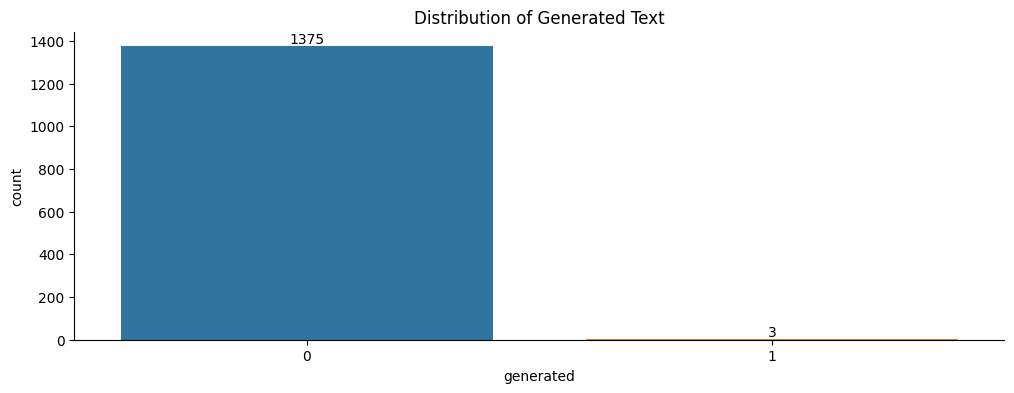

In [ ]:
# 1) 기존 Kaggle 대회에 있는 훈련 데이터 현황 확인
f, ax = plt.subplots(figsize=(12, 4)) # 도화지 준비(f : figure, ax : axis)
sns.despine() # 도화지 여백 제거
ax = sns.countplot(data=train_essays, x="generated")

# 2) abs_values 변수에 train 데이터에서 genertated 기준으로 빈도 분석
abs_values = train_essays['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values) # 각 막대에 레이블을 추가
ax.set_title("Distribution of Generated Text") # 그래프 제목 붙이기

# 3-2) 훈련 데이터 문장 길이 확인 & 필요 없는 열 제거

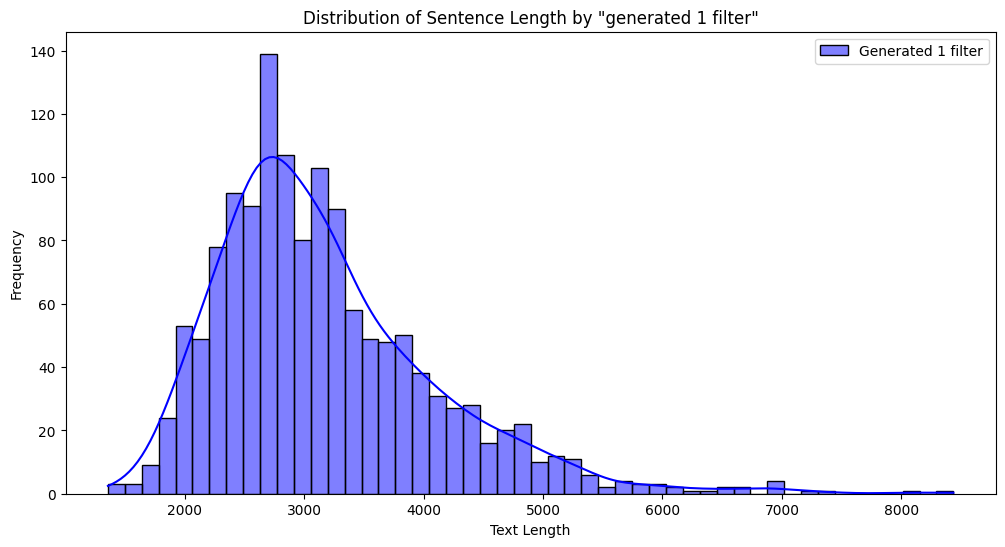

In [ ]:
# 1) 훈련 데이터 문장 길이 확인을 위한 데이터 처리
train_essays['text_length'] = train_essays['text'].apply(len) # 훈련데이터 길이 정보 추가
train_essays.drop(['id','prompt_id'],axis=1,inplace=True) # 필요없는 열 제거

# 2) 문장 길이 확인
plt.figure(figsize=(12, 6))
sns.histplot(train_essays['text_length'], bins=50, color='blue', label='Generated 1 filter', kde=True)
plt.title('Distribution of Sentence Length by "generated 1 filter"')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 3-3) 훈련 데이터 이상치 제거

In [ ]:
# 1) 훈련 데이터 이상치 제거
train_essays = train_essays.loc[(train_essays['text_length'] >= 746) & (train_essays['text_length'] <= 6000)]

# 2) 훈련 데이터 확인
print(train_essays.head())
print(train_essays.describe())
print(train_essays.info())

                                                text  generated  text_length
0  Cars. Cars have been around since they became ...          0         3289
1  Transportation is a large necessity in most co...          0         2738
2  "America's love affair with it's vehicles seem...          0         4428
3  How often do you ride in a car? Do you drive a...          0         4013
4  Cars are a wonderful thing. They are perhaps o...          0         4698
         generated  text_length
count  1362.000000  1362.000000
mean      0.002203  3125.391336
std       0.046898   829.878047
min       0.000000  1356.000000
25%       0.000000  2550.250000
50%       0.000000  2977.500000
75%       0.000000  3596.750000
max       1.000000  5977.000000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1362 entries, 0 to 1377
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         1362 non-null   object
 1   generated    136

# 4) 추가 훈련 데이터 전처리

# 4-1) 훈련 데이터 증강

In [ ]:
# 1) 추가할 훈련 데이터 2개의 파일을 합친다.
df_train_extra=pd.concat([train_extra,train_extra_2],ignore_index=True)

# 2) 기존 훈련 데이터와 합치기 위해 열의 레이블을 변경한다.
df_train_extra.rename(columns = {"label":"generated"}, inplace=True)

# 3) generated 열 값이 0인 행들만 추출하여 새로운 데이터프레임 생성
df_train_extra_stu1 = df_train_extra[df_train_extra['generated'] == 1]
df_train_extra_stu0 = df_train_extra[df_train_extra['generated'] == 0]
# df_train_extra_stu = df_train_extra_stu.drop(columns=["prompt_name", "RDizzl3_seven", 'model'])
# df_train_extra_stu = df_train_extra_stu[df_train_extra_stu['source'] == 'train_essays']

# 4) 새로운 데이터프레임 확인
print(df_train_extra_stu1)
print(df_train_extra_stu0)

                                                     text  generated  \
25996    In recent years, technology has had a profoun...          1   
25997   I strongly believe that meditation and mindful...          1   
25998   One way school administrators can attempt to c...          1   
25999   While summer is meant as a break from the regu...          1   
26000   The use of Facial Action Coding System (FACS) ...          1   
...                                                   ...        ...   
130770  Dear Senator,\n\nI am writing to you regarding...          1   
130771  I remember the day distinctively. I was sittin...          1   
130772  Dear Senator, \n\nI am writing this letter to ...          1   
130773  Dear Senator,\n\nI am writing to urge you to e...          1   
130774  It was a typical summer afternoon in my hometo...          1   

                             prompt_name                source  RDizzl3_seven  \
25996                    Car-free cities  mistral7bins

# 4-2) 추가 데이터중 우리가 원하는 prompts가 있는 데이터만 뽑아내기

In [ ]:
# 우리가 원하는 prompt 리스트
desired_prompts = ['Car-free cities', 'Does the electoral college work?']

# 우리가 원하는 prompt가 있는 데이터만 뽑아내기
df_train_extra_stu0 = df_train_extra_stu0[df_train_extra_stu0['prompt_name'].isin(desired_prompts)]
df_train_extra_stu1 = df_train_extra_stu1[df_train_extra_stu1['prompt_name'].isin(desired_prompts)]

# 데이터 확인
print(df_train_extra_stu0)
print(df_train_extra_stu1)

                                                     text  generated  \
1168    Cars have been around for awhile and they have...          0   
1169    Have you ever thought what it would be like no...          0   
1170    What you are about to read is going to give yo...          0   
1171    cars have many flaws nd and in this day and ag...          0   
1172    There are many advantages of limiting car usag...          0   
...                                                   ...        ...   
108969  There has been a fuss about the Elector Colleg...          0   
108970  Limiting car usage has many advantages. Such a...          0   
108971  There's a new trend that has been developing f...          0   
108972  As we all know cars are a big part of our soci...          0   
108973  Cars have been around since the 1800's and hav...          0   

                             prompt_name           source  RDizzl3_seven  \
1168                     Car-free cities  persuade_corpus  

# 4-3) 추가 데이터들 합치고 문장 길이 데이터 추가 & 필요없는 열 제거

In [ ]:
# 2개 추가 데이터 합치기
df_train_extra_stu = pd.concat([df_train_extra_stu0,df_train_extra_stu1])

# 문장 길이 데이터 추가
df_train_extra_stu['text_length'] = df_train_extra_stu['text'].apply(lambda x: len(str(x)))

# 필요 없는 열 제거
df_train_extra_stu.drop(['prompt_name','source','RDizzl3_seven','model'],axis=1,inplace=True)

# 추가할 데이터 확인
df_train_extra_stu.tail()

,text,generated,text_length
130770,"Dear Senator,\n\nI am writing to you regarding...",1,2173
130771,I remember the day distinctively. I was sittin...,1,2515
130772,"Dear Senator, \n\nI am writing this letter to ...",1,2305
130773,"Dear Senator,\n\nI am writing to urge you to e...",1,2298
130774,It was a typical summer afternoon in my hometo...,1,2146


# 4-4) 추가 데이터 확인

Text(0.5, 1.0, 'Distribution of Generated Text')

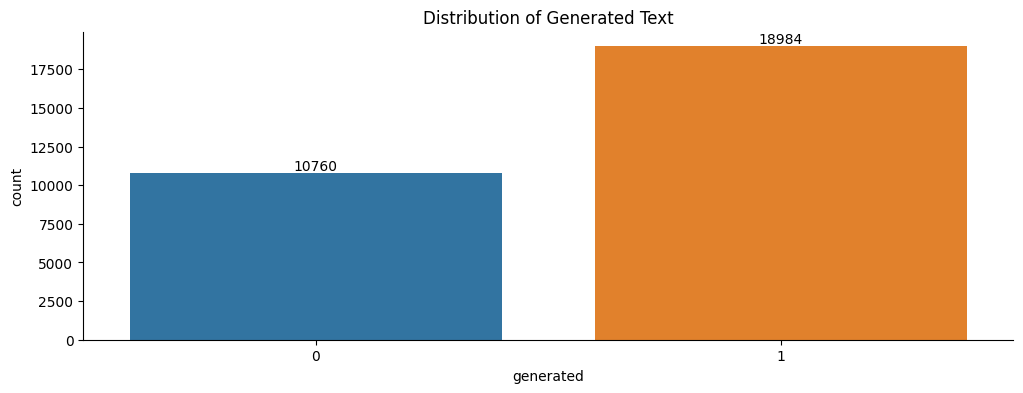

In [ ]:
# 추가 데이터 generated 기준으로 그래프 표현
f, ax = plt.subplots(figsize=(12, 4))
sns.despine()

ax = sns.countplot(data=df_train_extra_stu,x="generated",order=df_train_extra_stu['generated'].value_counts().index[::-1])  # 데이터를 뒤집어서 정렬
abs_values = df_train_extra_stu['generated'].value_counts().values[::-1]  # 데이터를 뒤집어서 정렬
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

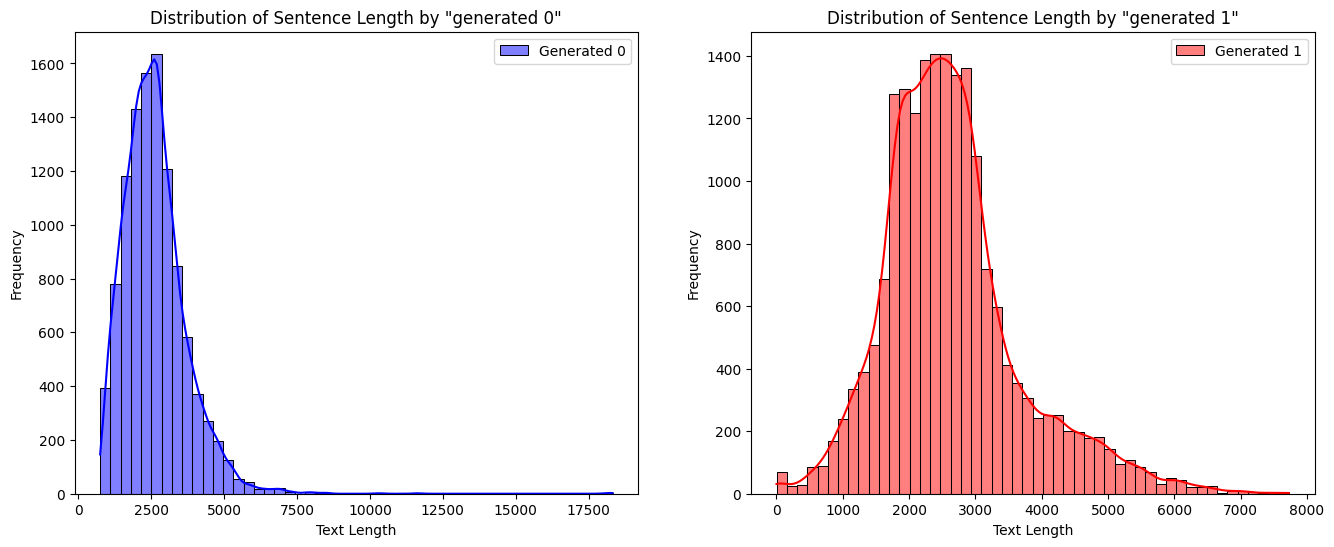

       generated   text_length
count    10760.0  10760.000000
mean         0.0   2628.838290
std          0.0   1084.918487
min          0.0    746.000000
25%          0.0   1901.000000
50%          0.0   2515.500000
75%          0.0   3172.000000
max          0.0  18322.000000
       generated  text_length
count    18984.0  18984.00000
mean         1.0   2643.69016
std          0.0   1043.95625
min          1.0      1.00000
25%          1.0   1956.00000
50%          1.0   2509.00000
75%          1.0   3069.00000
max          1.0   7729.00000


In [ ]:
# 1) 추가 데이터을 generated 기준으로 문장 길이 확인
# 1행 2열의 도화지 만들기
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# generated = 0일 때 문장의 길이 확인
sns.histplot(df_train_extra_stu[df_train_extra_stu['generated'] == 0]['text_length'], bins=50, color='blue', label='Generated 0', kde=True, ax=ax1)
ax1.set_title('Distribution of Sentence Length by "generated 0"')
ax1.set_xlabel('Text Length')
ax1.set_ylabel('Frequency')
ax1.legend()

# generated = 1일 때 문장의 길이 확인
sns.histplot(df_train_extra_stu[df_train_extra_stu['generated'] == 1]['text_length'], bins=50, color='red', label='Generated 1', kde=True, ax=ax2)
ax2.set_title('Distribution of Sentence Length by "generated 1"')
ax2.set_xlabel('Text Length')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.show()

# 2) generated 기준으로 데이터 세부 정보 확인
# generated 기준으로 나눠준다.
selected_rows1 = df_train_extra_stu[df_train_extra_stu['generated'] == 1]
selected_rows0 = df_train_extra_stu[df_train_extra_stu['generated'] == 0]

# 선택된 행들에 대해 describe를 수행합니다.
description1 = selected_rows1.describe()
description0 = selected_rows0.describe()

# 결과를 출력합니다.
print(description0)
print(description1)

# 4-5) 추가 데이터 이상치 제거

In [ ]:
# 문장의 길이가 746 ~ 6000인 것만 추출
filtered_rows0 = selected_rows0.loc[(selected_rows0['text_length'] >= 746) & (selected_rows0['text_length'] <= 6000)]
filtered_rows1 = selected_rows1.loc[(selected_rows1['text_length'] >= 746) & (selected_rows1['text_length'] <= 6000)]

# 이상치 제거후 데이터 세부 정보 확인
description_filtered0 = filtered_rows0.describe()
description_filtered1 = filtered_rows1.describe()

# 결과 확인
print(description_filtered0)
print(description_filtered1)

       generated   text_length
count    10676.0  10676.000000
mean         0.0   2589.535969
std          0.0    967.033043
min          0.0    746.000000
25%          0.0   1897.750000
50%          0.0   2499.500000
75%          0.0   3149.000000
max          0.0   5996.000000
       generated   text_length
count    18538.0  18538.000000
mean         1.0   2643.334772
std          0.0    953.136414
min          1.0    747.000000
25%          1.0   1977.250000
50%          1.0   2516.000000
75%          1.0   3060.000000
max          1.0   5999.000000


# 4-6) 이상치 제거후 문장의 길이 기준으로 데이터 확인

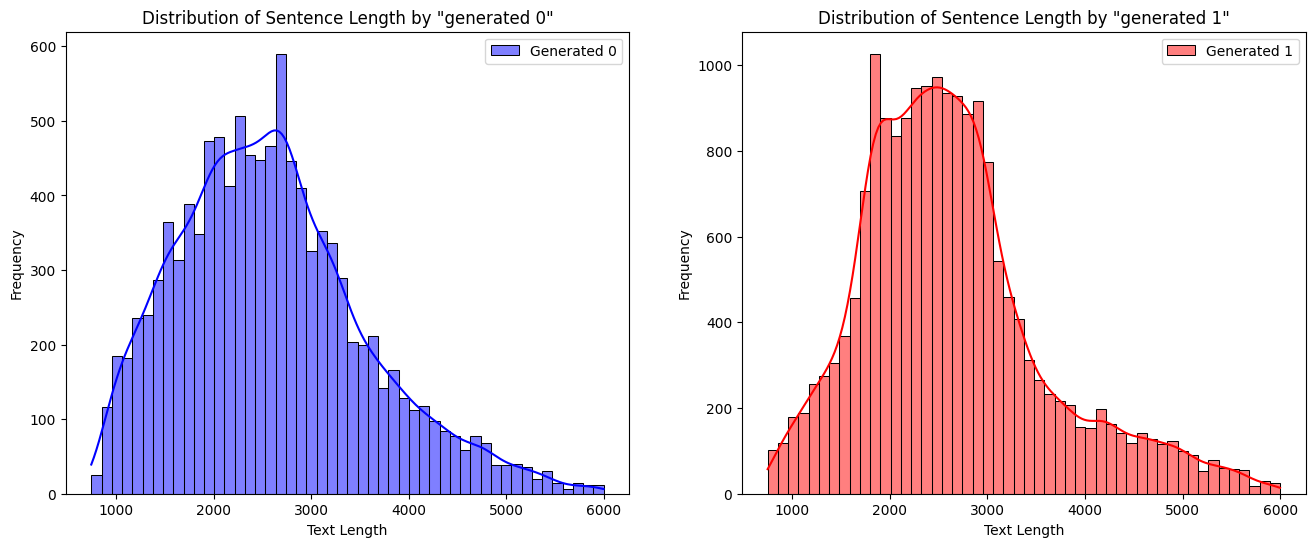

In [ ]:
# 도화지 설정
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# generated = 0인 경우 문장의 길이 확인
sns.histplot(filtered_rows0[filtered_rows0['generated'] == 0]['text_length'], bins=50, color='blue', label='Generated 0', kde=True, ax=ax1)
ax1.set_title('Distribution of Sentence Length by "generated 0"')
ax1.set_xlabel('Text Length')
ax1.set_ylabel('Frequency')
ax1.legend()

# generated=1인 경우 문장의 길이 확
sns.histplot(filtered_rows1[filtered_rows1['generated'] == 1]['text_length'], bins=50, color='red', label='Generated 1', kde=True, ax=ax2)
ax2.set_title('Distribution of Sentence Length by "generated 1"')
ax2.set_xlabel('Text Length')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.show()

# 5) 기존 데이터와 추가 데이터를 합치기

# 5-1) 기존 데이터와 추가 데이터를 합치기

Text(0.5, 1.0, 'Distribution of Generated Text')

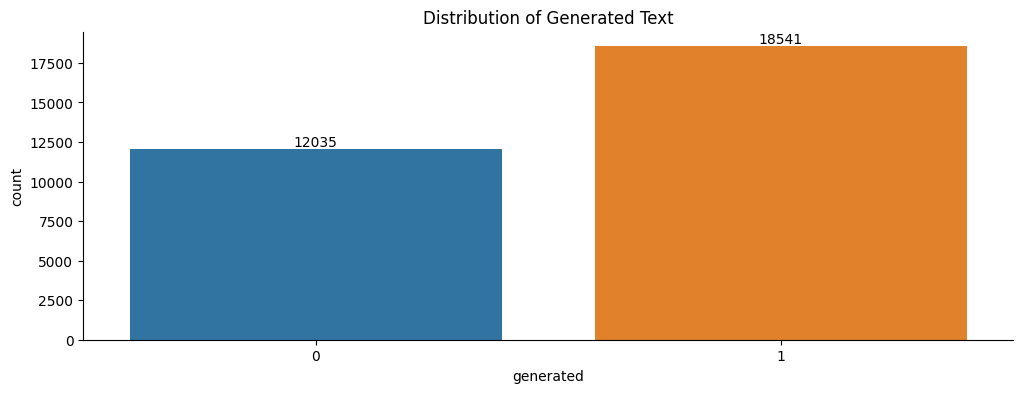

In [ ]:
# 1) 기존 데이터와 추가 데이터 합치기
df_train_essays_final = pd.concat([train_essays,filtered_rows0,filtered_rows1],axis=0)

# 2) generated 기준으로 데이터 확인
f, ax = plt.subplots(figsize=(12, 4))
sns.despine()

ax = sns.countplot(data=df_train_essays_final,x="generated",order=df_train_essays_final['generated'].value_counts().index[::-1])  # 데이터를 뒤집어서 정렬
abs_values = df_train_essays_final['generated'].value_counts().values[::-1]  # 데이터를 뒤집어서 정렬
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

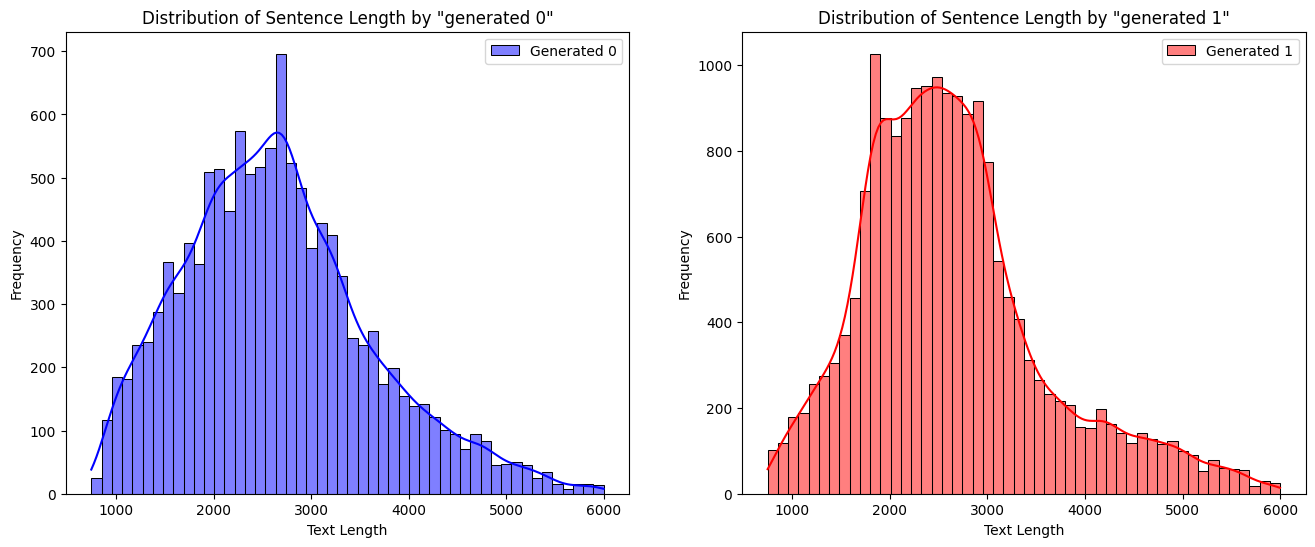

                                                text  generated
0  Cars. Cars have been around since they became ...          0
1  Transportation is a large necessity in most co...          0
2  "America's love affair with it's vehicles seem...          0
3  How often do you ride in a car? Do you drive a...          0
4  Cars are a wonderful thing. They are perhaps o...          0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30576 entries, 0 to 130774
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       30576 non-null  object
 1   generated  30576 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 716.6+ KB
None


In [ ]:
# 2) 문장의 길이 기준으로 데이터 확인
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# generated=0일 경우 문장의 길이 확인
sns.histplot(df_train_essays_final[df_train_essays_final['generated'] == 0]['text_length'], bins=50, color='blue', label='Generated 0', kde=True, ax=ax1)
ax1.set_title('Distribution of Sentence Length by "generated 0"')
ax1.set_xlabel('Text Length')
ax1.set_ylabel('Frequency')
ax1.legend()

# generated=1일 경우 문장의 길이 확인
sns.histplot(df_train_essays_final[df_train_essays_final['generated'] == 1]['text_length'], bins=50, color='red', label='Generated 1', kde=True, ax=ax2)
ax2.set_title('Distribution of Sentence Length by "generated 1"')
ax2.set_xlabel('Text Length')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.show()

# 문장의 길이 열을 제거후 최종 훈련 데이터 세부 정보 확인
df_train_essays_final.drop(['text_length'],axis=1,inplace=True)
print(df_train_essays_final.head())
print(df_train_essays_final.info())

# 5-2) 데이터 샘플링

In [ ]:
df_train_essays_final

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
130770,"Dear Senator,\n\nI am writing to you regarding...",1
130771,I remember the day distinctively. I was sittin...,1
130772,"Dear Senator, \n\nI am writing this letter to ...",1
130773,"Dear Senator,\n\nI am writing to urge you to e...",1


# 5-2-1) 언더 샘플링

In [ ]:
# # 클래스 0과 클래스 1의 데이터 개수 확인
# count_class_0 = len(df_train_essays_final[df_train_essays_final['generated'] == 0])
# count_class_1 = len(df_train_essays_final[df_train_essays_final['generated'] == 1])

# # 클래스 1의 데이터만 샘플링
# df_class_1 = df_train_essays_final[df_train_essays_final['generated'] == 1]
# df_class_1_under = df_class_1.sample(count_class_0, random_state=42)

# # 클래스 0의 데이터와 언더샘플링된 클래스 1의 데이터를 합쳐서 새로운 훈련 데이터 생성
# df_train_essays_final_balanced = pd.concat([df_class_1_under, df_train_essays_final[df_train_essays_final['generated'] == 0]], axis=0)

# # 샘플링 후의 데이터 확인
# f, ax = plt.subplots(figsize=(12, 4))
# sns.despine()
# ax = sns.countplot(data=df_train_essays_final_balanced, x="generated")

# abs_values = df_train_essays_final_balanced['generated'].value_counts().values
# ax.bar_label(container=ax.containers[0], labels=abs_values)
# ax.set_title("Distribution of Generated Text (Balanced)")

# df_train_essays_final = df_train_essays_final_balanced

# 5-2-2) 오버 샘플링

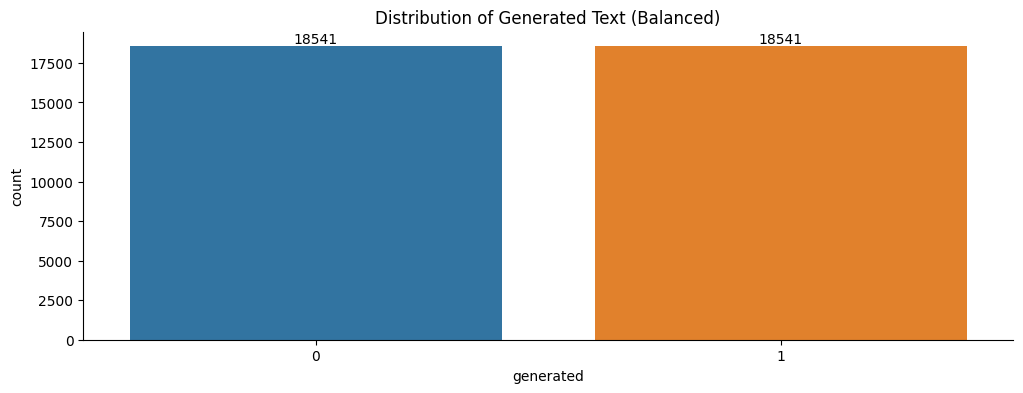

In [ ]:
# 클래스 0과 클래스 1의 데이터 개수 확인
count_class_0 = len(df_train_essays_final[df_train_essays_final['generated'] == 0])
count_class_1 = len(df_train_essays_final[df_train_essays_final['generated'] == 1])

# 클래스 0의 데이터만 샘플링 (오버샘플링)
df_class_0 = df_train_essays_final[df_train_essays_final['generated'] == 0]
df_class_0_over = df_class_0.sample(count_class_1, replace=True, random_state=42)

# 클래스 1의 데이터와 오버샘플링된 클래스 0의 데이터를 합쳐서 새로운 훈련 데이터 생성
df_train_essays_final_balanced = pd.concat([df_train_essays_final[df_train_essays_final['generated'] == 1], df_class_0_over], axis=0)

# 샘플링 후의 데이터 확인
f, ax = plt.subplots(figsize=(12, 4))
sns.despine()
ax = sns.countplot(data=df_train_essays_final_balanced, x="generated")

abs_values = df_train_essays_final_balanced['generated'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution of Generated Text (Balanced)")

df_train_essays_final = df_train_essays_final_balanced

# 6) 토큰화

# 6-1) 토큰화 진행후 각 문장의 토큰화 길이 분석

In [ ]:
# 'text'열에서 str 데이터 타입이 아닌 부분을 찾
problematic_data = df_train_essays_final[df_train_essays_final['text'].apply(lambda x: not isinstance(x, str))]
print(problematic_data)

# 토큰화 진행에 필요한 라이브러리
from transformers import RobertaTokenizer
from tqdm.auto import tqdm
import pandas as pd

# BERT 토크나이저 초기화
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# 각 문장마다 토큰 길이 계산(토큰화 진행)
token_lengths = [] # 각 문장 토큰 길이 저장
for text in df_train_essays_final['text']:  # 'text_column'은 텍스트가 포함된 컬럼 이름입니다.
    tokens = tokenizer.encode(text, add_special_tokens=True)
    token_lengths.append(len(tokens))


df_ = df_train_essays_final.copy()

# 토큰 길이를 DataFrame에 추가
df_['text'] = token_lengths

# 토큰 길이 기술 통계 분석
print(df_['text'].describe())

Empty DataFrame
Columns: [text, generated]
Index: []


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors


count    37082.000000
mean       540.883313
std        203.881008
min        147.000000
25%        407.000000
50%        517.000000
75%        640.000000
max       3991.000000
Name: text, dtype: float64


# 6-2) 토큰화 진행 후 토큰화된 데이터를 저장

In [ ]:
# tqdm을 사용하여 토큰화 진행 상황을 표시
input_ids = []
attention_masks = []

# 각 문장 리스트를 순회하며 토큰화 진
for text in tqdm(df_train_essays_final['text'].tolist(), desc="토큰화 진행중"):
    encoded = tokenizer.encode_plus(text,
                                    add_special_tokens=True,
                                    max_length=256,
                                    padding='max_length',
                                    truncation=True,
                                    return_attention_mask=True,
                                    return_tensors='np')
    # 각 문장에 대한 토튼화 결과에서 input_ids, attention_mask를 뽑아서 리스트화
    input_ids.append(encoded['input_ids'][0])
    attention_masks.append(encoded['attention_mask'][0])

# 토큰화된 데이터를 pandas DataFrame으로 변환
df_encoded = pd.DataFrame({
    'input_ids': input_ids,
    'attention_mask': attention_masks
})

# 토큰화된 데이터를 파일에 저장
df_encoded.to_csv('단어_TF_RoBERTa_encoded_data.csv', index=False)

토큰화 진행중:   0%|          | 0/37082 [00:00<?, ?it/s]

# 6-3) 토큰화된 데이터의 input_ids, attention_mask뽑아서 input data로 만들고 확인

In [ ]:
# 토큰화하고 input_ids와 attention_mask데이터추출하여 저장한 파일을 확인
df_encoded = pd.read_csv('단어_TF_RoBERTa_encoded_data.csv')
print(df_encoded.columns)
print()
df_encoded.head()

Index(['input_ids', 'attention_mask'], dtype='object')



,input_ids,attention_mask
0,[ 0 713 14700 40 11526 6 2268 ...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
1,[ 0 100 5025 679 14 5 14560 18...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
2,[ 0 44222 2838 512 304 4685 6631 ...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
3,[ 0 96 485 107 6 806 34 ...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
4,[ 0 44119 12 3698 19532 33 555 ...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...


In [ ]:
# 첫 번째 행의 'input_ids'와 'attention_mask' 열의 데이터 출력
first_row_input_ids = df_encoded['input_ids'].iloc[0]
first_row_attention_mask = df_encoded['attention_mask'].iloc[0]

first_row_input_ids, first_row_attention_mask

('[    0   713 14700    40 11526     6  2268     8  3364    65  1219    11\n  4402     9  2396     5 14560  1821    11     5   315   532    13    63\n  1939  1727     4   509     9     5  2188     7   489     5  7169  1564\n    16    14    24    16   357    13  2735     6    55  3826   982     7\n    33    55  2712    25  4340     7  2514 20887   911    14    33   739\n  9883     4    20 41752    31   209   982    32  4159    80  2834   349\n     4  2246    31  2514     6    55 18269   911    32  4159    95    65\n   900   349     4  7090   254   982  3805     7   946  1233   476   142\n    49    80  2834    13   394     8  2626   394  1606    62    55    87\n     5  2834     9  2514   982    14    33   171 41752     4   152    16\n   142     9     5  3462     9     5  7169  2834     4   993  5848    14\n 41752    32    45  8191     7   900    13     5  1984    54   351     5\n   144  2834  9852     4   252   109    45    33     7   900    13    49\n   308   194    18  6615  3867    49

In [ ]:
# 문자열을 정수 리스트로 변환하는 함수
def convert_string_to_int_list(string):
    try:
        # 줄바꿈, 대괄호 제거 및 쉼표로 분리
        cleaned_string = string.replace('\n', '').replace('[', '').replace(']', '')
        int_list = [int(i) for i in cleaned_string.split() if i.isdigit()]
        return int_list
    except:
        return []  # 변환에 실패한 경우 빈 리스트 반환

# 데이터프레임의 'input_ids' 열 변환
df_encoded['input_ids'] = df_encoded['input_ids'].apply(convert_string_to_int_list)

# 예시 출력
print(df_encoded.head())

                                           input_ids  \
0  [0, 713, 14700, 40, 11526, 6, 2268, 8, 3364, 6...   
1  [0, 100, 5025, 679, 14, 5, 14560, 1821, 197, 1...   
2  [0, 44222, 2838, 512, 304, 4685, 6631, 6, 3488...   
3  [0, 96, 485, 107, 6, 806, 34, 56, 10, 13960, 9...   
4  [0, 44119, 12, 3698, 19532, 33, 555, 10, 538, ...   

                                      attention_mask  
0  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...  
1  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...  
2  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...  
3  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...  
4  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...  


# 7) train set과 validation set 분리 후 확인

In [ ]:
# 라이브러리 불러오기, 분류 모델 불러오기
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split

model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
df_encoded

,input_ids,attention_mask
0,"[0, 713, 14700, 40, 11526, 6, 2268, 8, 3364, 6...",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
1,"[0, 100, 5025, 679, 14, 5, 14560, 1821, 197, 1...",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
2,"[0, 44222, 2838, 512, 304, 4685, 6631, 6, 3488...",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
3,"[0, 96, 485, 107, 6, 806, 34, 56, 10, 13960, 9...",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
4,"[0, 44119, 12, 3698, 19532, 33, 555, 10, 538, ...",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
...,...,...
37077,"[0, 3684, 198, 5, 232, 512, 304, 16, 8620, 8, ...",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
37078,"[0, 347, 2726, 33, 57, 10, 233, 9, 84, 2040, 1...",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
37079,"[0, 133, 14560, 1821, 16, 10, 609, 14, 197, 28...",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
37080,"[0, 133, 14560, 1821, 16, 10, 609, 156, 30, 5,...",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...


In [ ]:
# 데이터프레임에서 필요한 열만 선택(모델에 넣을 input 데이터)
df_encoded = df_encoded[['input_ids', 'attention_mask']]

# 'generated' 열은 레이블로 사용할 것이므로 따로 선택(input 데이터에 따른 ouput 데이터)
labels = df_train_essays_final['generated'].values

In [ ]:
print("df_encoded shape:", df_encoded.shape)
print("labels shape:", labels.shape)
print("labels shape:", labels)

df_encoded shape: (37082, 2)
labels shape: (37082,)
labels shape: [1 1 1 ... 0 0 0]


In [ ]:
# 학습 및 검증 데이터셋 분리(train data와 validation data 분리)
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(df_encoded, labels, random_state=2018, test_size=0.2)


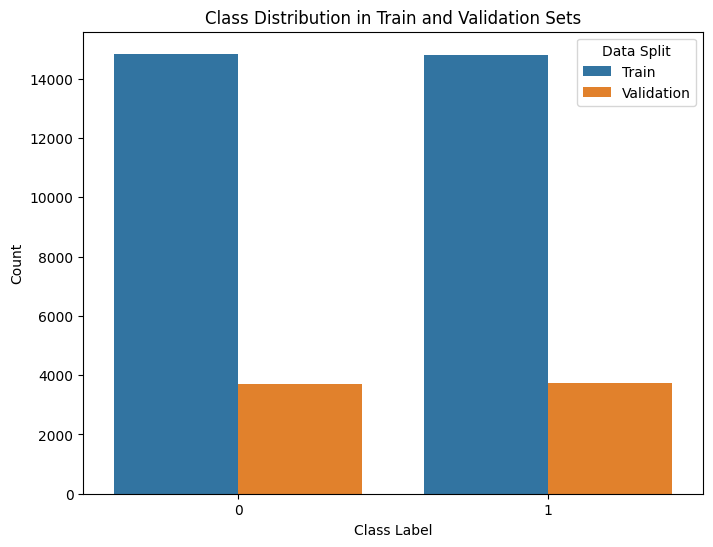

Number of data points with 'generated' label equal to 1 in Train set: 14846
Number of data points with 'generated' label equal to 1 in Validation set: 3695
Number of data points with 'generated' label equal to 1 in Train set: 14819
Number of data points with 'generated' label equal to 1 in Validation set: 3722


In [ ]:
# 클래스 분포 확인을 위한 데이터프레임 생성
train_df = pd.DataFrame({"Data Split": ["Train"] * len(train_labels), "Labels": train_labels})
validation_df = pd.DataFrame({"Data Split": ["Validation"] * len(validation_labels), "Labels": validation_labels})
combined_df = pd.concat([train_df, validation_df])

# 카운트 플롯 그리기
plt.figure(figsize=(8, 6))
sns.countplot(data=combined_df, x="Labels", hue="Data Split")
plt.title("Class Distribution in Train and Validation Sets")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.legend(title="Data Split")
plt.show()


# Train set에서 0의 개수 세기
train_generated_1_count = train_df[train_df["Labels"] == 0].shape[0]
print("Number of data points with 'generated' label equal to 1 in Train set:", train_generated_1_count)

# Validation set에서 0의 개수 세기
validation_generated_1_count = validation_df[validation_df["Labels"] == 0].shape[0]
print("Number of data points with 'generated' label equal to 1 in Validation set:", validation_generated_1_count)

# Train set에서 1의 개수 세기
train_generated_1_count = train_df[train_df["Labels"] == 1].shape[0]
print("Number of data points with 'generated' label equal to 1 in Train set:", train_generated_1_count)

# Validation set에서 1의 개수 세기
validation_generated_1_count = validation_df[validation_df["Labels"] == 1].shape[0]
print("Number of data points with 'generated' label equal to 1 in Validation set:", validation_generated_1_count)

In [ ]:
# train_input data 준비
train_inputs = {
    "input_ids": np.array(train_inputs["input_ids"].to_list()),
    "attention_mask": np.array(train_inputs["attention_mask"].to_list())
}

# train_labels data 준비
train_labels = np.array(train_labels)

# validation_input data 준비
validation_inputs = {
    "input_ids": np.array(validation_inputs["input_ids"].to_list()),
    "attention_mask": np.array(validation_inputs["attention_mask"].to_list())
}

# validation_labels data 준비
validation_labels = np.array(validation_labels)

print("train_inputs shape:", train_inputs["input_ids"].shape)
print("validation_inputs shape:", validation_inputs["input_ids"].shape)
print("train_labels shape:", train_labels.shape)
print("validation_labels shape:", validation_labels.shape)

train_inputs shape: (29665, 256)
validation_inputs shape: (7417, 256)
train_labels shape: (29665,)
validation_labels shape: (7417,)


# 8) 모델 학습 단계

In [ ]:
# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# 문자열을 정수 리스트로 변환하는 함수
def convert_string_to_int_array(string_array):
    int_arrays = []
    for string in string_array:
        # 문자열을 정수 리스트로 변환
        int_list = [int(i) for i in string.split() if i.isdigit()]
        int_arrays.append(int_list)
    return np.array(int_arrays, dtype=int)

# 'attention_mask'의 문자열을 정수 배열로 변환
train_inputs['attention_mask'] = convert_string_to_int_array(train_inputs['attention_mask'])
validation_inputs['attention_mask'] = convert_string_to_int_array(validation_inputs['attention_mask'])

# 변환 후 데이터 타입 재확인
print("After conversion - train_inputs[attention_mask] type:", train_inputs['attention_mask'].dtype)
print("After conversion - validation_inputs[attention_mask] type:", validation_inputs['attention_mask'].dtype)

After conversion - train_inputs[attention_mask] type: int64
After conversion - validation_inputs[attention_mask] type: int64


In [ ]:
# 입력 데이터 형상 확인
print("train_inputs[input_ids] shape:", train_inputs['input_ids'].shape)
print("train_inputs[attention_mask] shape:", train_inputs['attention_mask'].shape)
print("validation_inputs[input_ids] shape:", validation_inputs['input_ids'].shape)
print("validation_inputs[attention_mask] shape:", validation_inputs['attention_mask'].shape)

# 필요한 경우 패딩 또는 트리밍 수행
# 예시: train_inputs['input_ids'] = pad_or_trim(train_inputs['input_ids'], desired_length)

# 모델 학습을 다시 시도

train_inputs[input_ids] shape: (29665, 256)
train_inputs[attention_mask] shape: (29665, 254)
validation_inputs[input_ids] shape: (7417, 256)
validation_inputs[attention_mask] shape: (7417, 254)


In [ ]:
# attention_mask에 패딩 추가
train_inputs['attention_mask'] = np.pad(train_inputs['attention_mask'],
                                        ((0, 0), (0, 2)),  # (데이터 시작부터 끝까지, 2개 패딩 추가)
                                        mode='constant',
                                        constant_values=0)

validation_inputs['attention_mask'] = np.pad(validation_inputs['attention_mask'],
                                             ((0, 0), (0, 2)),
                                             mode='constant',
                                             constant_values=0)

# 변환 후 데이터 형상 재확인
print("After padding - train_inputs[attention_mask] shape:", train_inputs['attention_mask'].shape)
print("After padding - validation_inputs[attention_mask] shape:", validation_inputs['attention_mask'].shape)

After padding - train_inputs[attention_mask] shape: (29665, 256)
After padding - validation_inputs[attention_mask] shape: (7417, 256)


In [ ]:
from keras.callbacks import ModelCheckpoint

# 배치 크기 설정
batch_size = 8

# 체크포인트 파일 경로 설정
checkpoint_path = "best_model"

# ModelCheckpoint 콜백 생성 (Tensorflow SavedModel 포맷으로 저장)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_format="tf")

# 모델 학습 시도하면서 콜백 추가
history = model.fit(
    train_inputs,
    train_labels,
    epochs=5,
    batch_size=batch_size,
    validation_data=(validation_inputs, validation_labels),
    callbacks=[checkpoint]
)

Epoch 1/5
3709/3709 [==============================] - ETA: 0s - loss: 0.0315 - accuracy: 0.9892
Epoch 1: val_loss improved from inf to 0.00699, saving model to best_model
3709/3709 [==============================] - 1921s 505ms/step - loss: 0.0315 - accuracy: 0.9892 - val_loss: 0.0070 - val_accuracy: 0.9974
Epoch 2/5
3709/3709 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9966
Epoch 2: val_loss improved from 0.00699 to 0.00153, saving model to best_model
3709/3709 [==============================] - 1876s 506ms/step - loss: 0.0112 - accuracy: 0.9966 - val_loss: 0.0015 - val_accuracy: 0.9997
Epoch 3/5
3709/3709 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9979
Epoch 3: val_loss did not improve from 0.00153
3709/3709 [==============================] - 1830s 493ms/step - loss: 0.0080 - accuracy: 0.9979 - val_loss: 0.0024 - val_accuracy: 0.9993
Epoch 4/5
3709/3709 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.99

# 9) 모델 평가

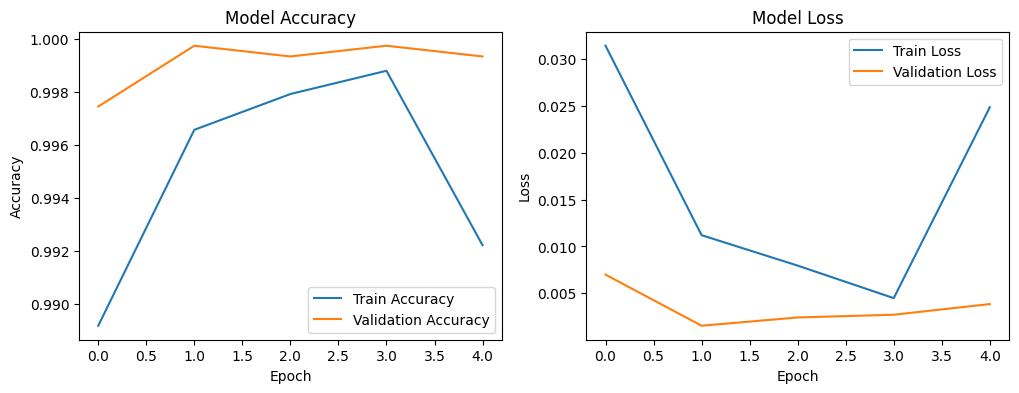

In [ ]:
import matplotlib.pyplot as plt

# 정확도 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

232/232 [==============================] - 133s 561ms/step


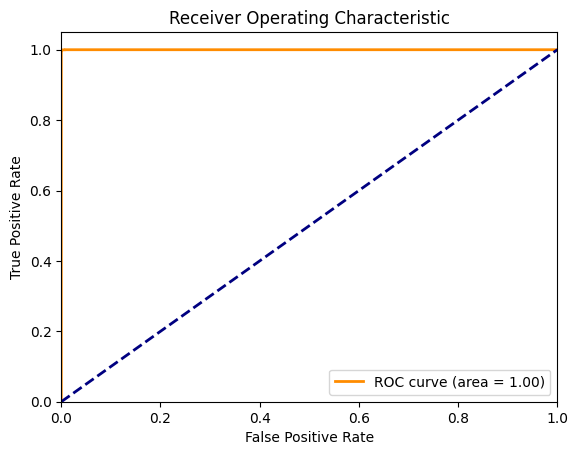

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 검증 데이터에 대한 예측 로짓을 얻음
y_pred_logits = model.predict(validation_inputs).logits

# 로짓을 확률로 변환 (이진 분류 가정)
y_pred_probs = tf.nn.softmax(y_pred_logits, axis=1)[:, 1].numpy()

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(validation_labels, y_pred_probs)

# AUC 계산
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()